# __고객 분석__
- __고객 분석(customer analysis)__이란 고객의 행동 데이터를 통해 시장을 세분화하고 예측 분석을 함으로써 가장 중요한 사업상 결정을 이끌어내는 과정을 말한다.
- __시장 세분화(market segmentation)__란 사용자 행동과 다른 유형의 공유 특성을 기반으로 사용자 기반 군집으로 나누는 과정을 말한다.
- 이는 각 __사용자 부문(user segment)__별로 맞춤형 제품을 제공하는 데 도움이 된다.
- 회사들은 다이렉트 마케팅(direct marketing), 부지 선정(site selection), 고객 확보(customer acquisition), 고객 관계 관리(customer relationship management, CRM)를 위해 시장 세분화 및 예측 모델에 의해 생성된 결과를 활용할 수 있다.

### index

- 연구문제 진술 소개
- 데이터셋 이해
- 고객 세분화를 위한 기준 접근법 구축 :
    - 기준 접근법 구현
    - 테스트 계량 이해
    - 기준 접근법의 결과 테스트
    - 기준 접근법의 문제점
    - 기준 접근법 최적화
- 고객 세분화를 위한 개선 접근법 구축 :
    - 개선 접근법 구현
    - 개선 접근법 테스트
    - 개선 접근법 문제점
    - 개선 접근법을 개선하는 방법 이해
- 고객 세분화를 위한 최선 접근법 :
    - 최선 접근법 구현
- 최선 접근법 테스트
- 다양한 분야에 대한 고객 세분화

# 1. 연구문제 소개
- 연구문제 :
    1. 고객의 구매 패턴에 따라 특정 부문에 고객을 범주화할 수 있다.
    2. 고객 세분화를 기준으로 향후에 어떤 제품을 구매할지를 예측할 수 있다.
- Input Data : 고객 4000명의 전자상거래 데이터(1년간의 구매 데이터)
- Output : 
    1. 고객 기반의 고객 부문 분류
    2. 고객의 첫번째 구매를 기준으로 금년과 내년의 구매를 예측

# 2. 데이터셋의 이해

- The UCI Machine Learning Repository에서 제공하는 Online Retail Dataset : 영국 소매 업체의 실제 거래 데이터
- 2010년 12월 1일부터 2011년 12월 9일까지의 실제 거래 데이터
- 사계절용 선물 판매에 대한 기록
- 소비자는 대체로 도매업체이다.
- 532,610개의 레코드

|변수명|설명|비고|
|:-----|:------|:------|
|1. InvoiceNo|송장번호|6자리 정수. 고유번호. c로 시작하면 취소를 나타낸다.|
|2. StockCode|재고번호|5자리 정수. 각 제품에 고유하게 지정된다.|
|3. Description|품목설명||
|4. Quantity|거래당 각 제품의 수량|숫자형식|
|5. InvoiceDate|송장 날짜와 시간|각 거래가 생성된 날짜와 시간|
|6. UnitPrice|단위 당 가격|영국 파운드화|
|7. CustomerID|고객 ID 번호|각 고객에게 할당된 고유5자리 번호|
|8. Country|고객의 지리적 정보|고객의 나라이름|

# 3. Baseline 구현

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML

# 1) 데이터 준비

In [2]:
df_init = pd.read_csv("./data/data.csv",
                      encoding="ISO-8859-1",
                     dtype={'CustomerID':str, 'InvoiceID':str})
print("DataFrame dimensions:", df_init.shape)
df_init['InvoiceDate'] = pd.to_datetime(df_init['InvoiceDate'])

DataFrame dimensions: (541909, 8)


In [3]:
df_init.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


# 2) EDA

## a. 결측치 제거

In [4]:
tab_info=pd.DataFrame(df_init.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_init.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_init.isnull().sum()/df_init.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
tab_info

---------- Display information about column types and number of null values ----------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


- 결측치 정보를 살펴보면 CustomerID 중 24%의 데이터가 CustomerID가 없는 것을 알 수 있다.
- 이는 이상 종료 데이터 입력에 해당한다.
- 기존의 CustomerID에 대응시킬 수 없기때문에 이 데이터들은 삭제한다.

In [5]:
df_init.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_init.shape)
tab_info=pd.DataFrame(df_init.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_init.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_init.isnull().sum()/df_init.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
tab_info

Dataframe dimensions: (406829, 8)
---------- Display information about column types and number of null values ----------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


## b. 중복 데이터 입력 제거

In [6]:
# 중복되는 5225개의 데이터를 삭제
print('Duplicate data entries: {}'.format(df_init.duplicated().sum()))
df_init.drop_duplicates(inplace = True)

Duplicate data entries: 5225


## c. 다양한 데이터 특성을 위한 EDA

## 1) 국가별

In [7]:
temp = df_init[['CustomerID', 'InvoiceNo','Country']].groupby(['CustomerID','InvoiceNo','Country']).count()
temp = temp.reset_index(drop=False)
countries = temp['Country'].value_counts()
print('No. of cuntries in dataframe: {}'.format(len(countries)))

No. of cuntries in dataframe: 37


In [8]:
temp_no_of_order_per_count = df_init[['CustomerID','Country']].groupby(['Country']).count()
temp_no_of_order_per_count = temp_no_of_order_per_count.reset_index(drop = False)

print('-' * 10 + " Contry-wise order calculation "+ '-' * 10)
print
print (temp_no_of_order_per_count.sort_values(
    by='CustomerID', ascending=False).rename(index=str,
                                        columns={"CustomerID": "Country wise number of order"}))

---------- Contry-wise order calculation ----------
                 Country  Country wise number of order
35        United Kingdom                        356728
14               Germany                          9480
13                France                          8475
10                  EIRE                          7475
30                 Spain                          2528
23           Netherlands                          2371
3                Belgium                          2069
32           Switzerland                          1877
26              Portugal                          1471
0              Australia                          1258
24                Norway                          1086
18                 Italy                           803
6        Channel Islands                           757
12               Finland                           695
7                 Cyprus                           611
31                Sweden                           461
1            

## 2) 고객 및 제품 별

In [9]:
# value_counts()함수를 이용하여 사용자와 제품의 수를 파악한다.

pd.DataFrame([{'products': len(df_init['StockCode'].value_counts()),    
               'transactions': len(df_init['InvoiceNo'].value_counts()),
               'customers': len(df_init['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], 
              index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [10]:
# 얼마나 많은 제품이 매 거래마다 구매되었는지 확인한다.
# InvoiceNo와 InvoiceDate 데이터 특성을 이용하여 모든 거래에서 구매한 제품 수를 계산한다.
temp = df_init.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


- CustomerID 12346번을 보면 한가지 상품을 한번 구매한 경우도 존재한다는 것을 알 수 있다.
- 또한 InvoiceNo에 C가 붙어있는 것을 보면 거래를 취소한 경우도 있다는 것을 알 수 있다.
- CustomerID 12347을 보면 한 사용자가 여러가지 물건을 여러번 구입했다는 것을 확인 할 수 있다.

## 3) 제품 범주 별

In [11]:
# InvoiceNo에 C가 있으면 정수 1을 반환하는 람다함수를 사용하여 취소건수의 갯수를 파악한다.
nb_products_per_basket['order_cancelled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: int('C' in x))
display(nb_products_per_basket.head())

n1 = nb_products_per_basket['order_cancelled'].sum()
n2 = nb_products_per_basket.shape[0]
percentage = (n1 / n2) * 100
print('취소된 주문건수 : {}/{} ({:.2f}%) '.format(n1,n2,percentage))

,CustomerID,InvoiceNo,Number of products,order_cancelled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


취소된 주문건수 : 3654/22190 (16.47%) 


In [12]:
# 다시 원래 데이터로 돌아가서 취소 건들을 어떻게 처리할지에 대해 알아본다.
df_init.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


- 위의 데이터 일부를 통해 알 수 있듯이, 취소건의 경우 수량과 송장 날짜를 제외한 부분은 동일하다.
- 먼저 모든 데이터가 이러한 경우를 만족하는지 확인한다.
- 일부 할인 입력 내역도 있지만 할인 입력 내역은 버리는 것으로 한다.

In [13]:
df_check = df_init[df_init['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]

In [14]:
for index, col in df_check.iterrows():
    if df_init[(df_init['CustomerID'] == col[0]) & 
               (df_init['Quantity'] == -col[1]) & 
               (df_init['Description'] == col[2])].shape[0] == 0:
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

141 CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


- 위의 코드를 실행하면 취소된 모든 거래에 유사한 입력이 없다는 것을 알 수 있다.
- 데이터 프레임에 거래가 취소되었는지 여부를 나타내는 새로운 변수를 생성한다.
- 취소된 주문에는 세가지 종류가 있다.
    1. 상대방 없이 거래가 취소된 경우 
        - 일부는 구매 주문이 2010년 12월 이전에 진행됐다.
    2. 정확하게 상대방 한 명이 취소한 경우
    3. 의심스러운 입력.
        - 정확히 같은 수량이 가능한 상대방이 있는지 확인한다. 
        - 확인 후 의심스러운 입력이라면 별도로 표시한다.

In [15]:
df_cleaned = df_init.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtful_entry = []

for index, col in df_init.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount':
        continue
    df_test = df_init[(df_init['CustomerID'] == col['CustomerID']) &
                      (df_init['StockCode'] == col['StockCode']) &
                      (df_init['InvoiceDate'] < col['InvoiceDate']) &
                      (df_init['Quantity'] > 0)
                     ].copy()
    # 상대방 없이 취소한 경우
    if (df_test.shape[0] == 0):
        doubtful_entry.append(index)
    
    # 상대방이 존재하는 취소 경우
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
    
    # 여러 상대방이 존재하는  주문건들 : 마지막 건은 지운다.
    
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0, ascending=False, inplace=True)
        for idx, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']:
                continue
            df_cleaned.loc[idx, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [16]:
print("entry_to_remove : {}".format(len(entry_to_remove)))
print("doubtful_entry : {}".format(len(doubtful_entry)))

entry_to_remove : 7521
doubtful_entry : 1226


- 7,521개의 입력이 주문 취소와 함께 표시된다.
- 1,226개의 입력이 있으며 해당 입력이 없는 주문 취소가 표시된다.
- 간단하게 하기 위해 주문 취소와 관련된 모든 입력을 삭제한다.

In [17]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [18]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


- 주문취소를 식별하면서 재고번호(StockCode)를 기준으로 할인 입력을 하는 것을 발견했다.
- 이를 통해 재고 번호를 기반으로 입력을 분석해본다.

In [19]:
# 재고번호 나열
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [20]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


- 개별 주문 가격 책정에 대해 초점을 맞추었을 때, 주어진 데이터셋에서 단일 고객의 주문이 여러줄로 나뉜다.
- 데이터 셋의 각 입력은 단일 종류 제품에 대한 가격을 나타낸다. 한 고객이 여러 제품을 주문한 경우에 해당 주문에는 입력 내역이 여러 개가 있게 된다.
- 데이터 입력의 수는 주문한 제품 수에 따라 다르다.
- 따라서 TotalPrice라는 컬럼을 추가하여 각 주문에 대한 총액을 얻는다.

In [21]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] = (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,0,12346,United Kingdom,74215,0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4,12347,Iceland,0,4
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,12,12347,Iceland,0,12
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,10,12347,Iceland,0,10
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,6,12347,Iceland,0,6


- 총액을 구한 다음, 개별 주문에 대한 합계를 생성한다.
- 송장 데이터를 기반으로 그룹화를 하고 그룹화된 가격('Basket Price')가 0보다 큰 데이터만 불러온다.

In [22]:
# 모든 구매 / 구매자 & 주문건
temp = df_cleaned.groupby(by=['CustomerID','InvoiceNo'],
                         as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice':'Basket Price'})

In [23]:
# 주문 날짜

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

In [24]:
# 중요한 품목 선택

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values("CustomerID")[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,319,2010-12-07 14:57:00.000001024
2,12347,542237,315,2011-01-26 14:29:59.999999744
3,12347,549222,483,2011-04-07 10:42:59.999999232
4,12347,556201,196,2011-06-09 13:01:00.000000256
5,12347,562032,277,2011-08-02 08:48:00.000000000
6,12347,573511,676,2011-10-31 12:25:00.000001280


Text(0.5, 1.01, 'Distribution of order amounts')

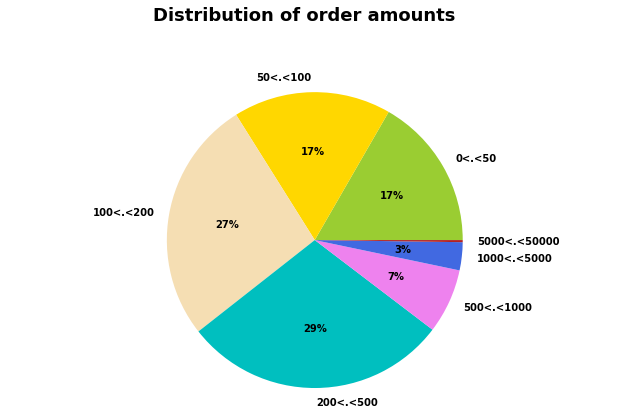

In [25]:
# 구매량 카운트
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
    
# 전체 중 구매한 횟수에 대한 시각화

plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11,6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels = labels, colors = colors,
      autopct = lambda x: '{:1.0f}%'.format(x) if x > 1 else '',
      shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, 'Distribution of order amounts', ha='center', fontsize=18)

- 그래프에서 확인 할 수 있듯이 전체 주문의 약 65%는 200파운드 이상이다.

## 4) 제품 범주 정의
- 제품 설명 분석
- 제품 범주 정의
- 군집 내용의 특성화

## 제품 설명 분석
- 여기서는 두 가지 데이터 특성을 사용한다.
- StockCode라는 데이터 특성을 사용한다.
- 이 특성에는 각 제품의 고슈 식별 번호(ID)가 들어있다.
- 또한 Description이라는 특성을 사용해 제품을 여러 범주로 그룹화한다.

In [26]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer('english')
    keywords_roots = dict()
    keywords_select = dict()
    category_keys = []
    count_keywords = dict()
    icount = 0
    
    for s in dataframe[colonne]:
        if pd.isnull(s):
            continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        
        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] +=1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
            
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
    print("number of keywords in variable '{}' : {}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [30]:
df_products = pd.DataFrame(df_init['Description'].unique()).rename(columns = {0:'Description'})

In [32]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

number of keywords in variable 'Description' : 1484


- keyword :  추출된 이름들로된 리스트
- keywords_roots : 키가 이름의 어근이고 값이 어근 이름과 연관된 이름의 딕셔너리
- Count_keywords : 각 이름의 빈도를 추적하는 딕셔너리이다. Count는 특정 이름이 출현한 횟수를 나타낸다.

In [34]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

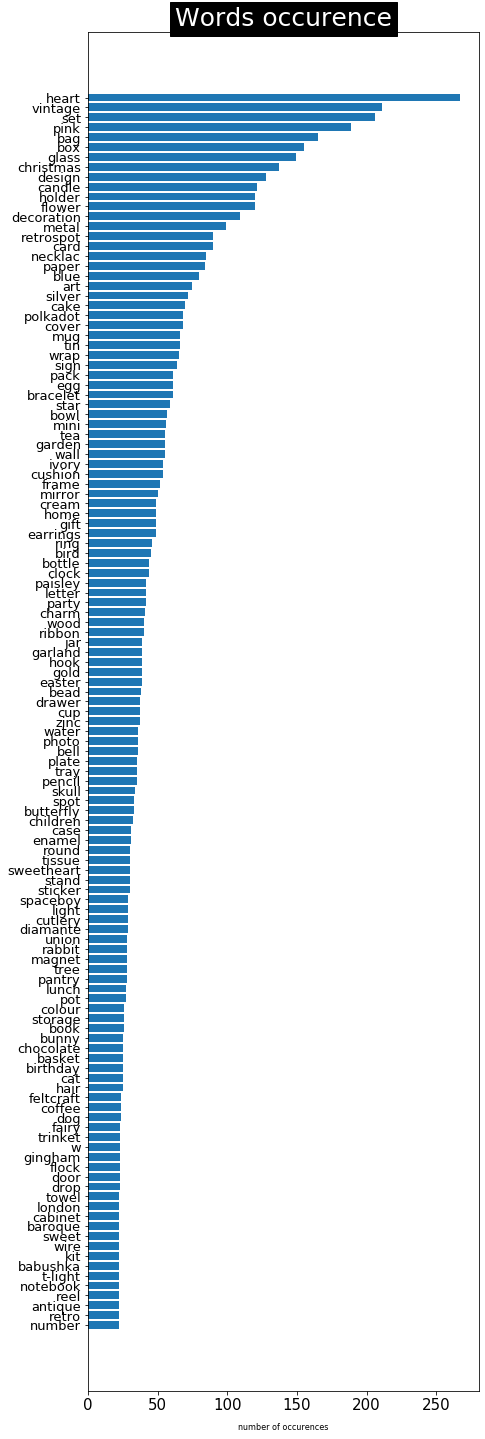

In [37]:
liste = sorted(list_products, key=lambda x:x[1], reverse=True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7,25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k, i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]

plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.yticks(x_axis, x_label)
plt.xlabel("number of occurences", fontsize=8, labelpad=10)
ax.barh(x_axis, y_axis, align='center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence", bbox={'facecolor':'k', 'pad':5},
         color='w',
         fontsize=25)
plt.show()

## 제품 범주 정의
- 이 부분에서는 제품 범주를 정의한다.
- 앞서서 얻은 1400개 이상의 핵심어를 사용하여 가장 많이 사용되는 이름들을 200개 정도로 추출했다.
- 13번 이상 나타나는 단어만 고려한다.

In [38]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
    
list_products.sort(key=lambda x: x[1], reverse=True)
print('Preserved words:', len(list_products))

Preserved words: 193


- One-Hot encoding을 사용하여 텍스트 데이터를 숫자형식으로 변환한다.
- 다음으로 가격대를 기준으로 제품에 대한 군집을 생성한다.
- 이를 위해 생성된 핵심어 목록을 사용하고 제품 설명에 핵심어에 포함된 단어가 있는지 확인한다.
- UnitPrice(단가)의 평균값을 사용한다.

In [43]:
liste_products = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

In [44]:
threshold = [0,1,2,3,5,10]
label_col = []

for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0
    
for i, prod in enumerate(liste_products):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j += 1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [45]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       122                 
1<.<2       299                 
2<.<3       358                 
3<.<5       572                 
5<.<10      1089                
.>10        1438                


## 3-3) 고객 범주 생성

## 3-4) 고객 분류